# **MeCabのインストール（形態素解析器）**

説明は省略 （MeCab：奈良先端大の松本研究室で開発された形態素解析器）

In [ ]:
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

# **ipadic-neologdのインストール（辞書データ）**

説明は省略 （ipadic-neologd：ipadicに固有名詞の辞書を追加）

In [ ]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

# **Python中でMeCabをimportして利用する方法**



通常のipadicを使った形態素解析 （固有名詞の扱いに弱い）

In [3]:
import MeCab

m = MeCab.Tagger()

str_sent = "東京大学で自然言語処理を講義する"

print(m.parse(str_sent))

東京大学	名詞,固有名詞,組織,*,*,*,東京大学,トウキョウダイガク,トーキョーダイガク
で	助詞,格助詞,一般,*,*,*,で,デ,デ
自然	名詞,形容動詞語幹,*,*,*,*,自然,シゼン,シゼン
言語	名詞,一般,*,*,*,*,言語,ゲンゴ,ゲンゴ
処理	名詞,サ変接続,*,*,*,*,処理,ショリ,ショリ
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
講義	名詞,サ変接続,*,*,*,*,講義,コウギ,コーギ
する	動詞,自立,*,*,サ変・スル,基本形,する,スル,スル
EOS



ipadic-neologdを使った形態素解析（固有名詞に対して頑健な解析が可能）

In [14]:
import subprocess

cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode("UTF-8")
m = MeCab.Tagger("-d {0}".format(path))

print(m.parse(str_sent))

東京大学	名詞,固有名詞,組織,*,*,*,東京大学,トウキョウダイガク,トーキョーダイガク
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
国立大学	名詞,固有名詞,一般,*,*,*,国立大学,コクリツダイガク,コクリツダイガク
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
。	記号,句点,*,*,*,*,。,。,。
東京大学	名詞,固有名詞,組織,*,*,*,東京大学,トウキョウダイガク,トーキョーダイガク
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
東京都	名詞,固有名詞,地域,一般,*,*,東京都,トウキョウト,トーキョート
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
あり	動詞,自立,*,*,五段・ラ行,連用形,ある,アリ,アリ
ます	助動詞,*,*,*,特殊・マス,基本形,ます,マス,マス
。	記号,句点,*,*,*,*,。,。,。
EOS



分かち書き（単語分割）の結果のみを取得するオプション

In [15]:
m = MeCab.Tagger("-Owakati -d {0}".format(path))

words = m.parse(str_sent)
words = words.rstrip("\n")
print(words)

東京大学 は 国立大学 です 。 東京大学 は 東京都 に あり ます 。 


# **名詞頻度の書き出し**

テキスト中に出現する名詞の頻度を計算

In [16]:
# coding:utf-8

import sys
import MeCab
import collections

# 名詞抽出用クラス MeCabオブジェクトの再生成を避けるために定義
class Extractor:
    # コンストラクタ
    def __init__(self):
        # self.m = MeCab.Tagger()
        cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
        path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode("UTF-8")
        self.m = MeCab.Tagger("-d {0}".format(path))

    # 一行に含まれている全ての名詞を重複を許してリストに追加
    def ext_nouns(self,line):
        nouns = []
        # -Owakatiオプションの際は空で結果を返す
        #if self.opt_flag:
        #    return nouns
        for row in self.m.parse(line).splitlines():
            if row == "" or row == "EOS":
                continue
            (word, features) = row.split("\t")
            if features.startswith(("名詞,非自立")):
                continue
            if features.startswith("名詞"):
                nouns.append(word)
        return nouns

    # 一行に含まれている余計な単語を除去し、単語の重複を許して文字列化
    def ext_segment(self,line):
        words = []
        for row in self.m.parse(line).splitlines():
          if row == "" or row == "EOS":
                continue
          (word, features) = row.split("\t")
          if features.startswith(("名詞,非自立")):
                continue
          if features.startswith(("名詞", "形容詞")):
                words.append(word)
        return " ".join(words)

In [17]:
nouns = []

# 名詞抽出用オブジェクトを生成
extractor = Extractor()

# 抽出された名詞を追加
str_sent = "東京大学は国立大学です。東京大学は東京都にあります。"

nouns.extend(extractor.ext_nouns(str_sent))

# 名詞のリストを(単語, 頻度)の辞書型に変換
freq_nouns = collections.Counter(nouns)

# 辞書を降順にソートして出力
for word, freq in sorted(freq_nouns.items(), key=lambda x: -x[1]):
    print(str(word) + "\t" + str(freq))

東京大学	2
国立大学	1
東京都	1


# **Googleドライブを現在接続しているサーバにマウント**

自身のGoogleドライブをサーバにマウント

Googleドライブ上でファイルの読み書きができる

In [8]:
from google.colab import drive

# Googleドライブをマウント
drive.mount('/content/drive')

Mounted at /content/drive


# **Googleドライブ上でファイルの読み書きを行う**

事前に用意したテキストデータ「形態素解析器MeCabの使い方/dataset/sports-livedoor.txt」をファイル入力

*   livedoorニュースコーパスを使用
*   クリエイティブ・コモンズライセンス「表示 - 改変禁止」　http://creativecommons.org/licenses/by-nd/2.1/jp/
*   掲載元 https://www.rondhuit.com/download.html

名詞の出現頻度を「形態素解析器MeCabの使い方/results/freq_nouns.csv」にファイル出力

In [18]:
# coding:utf-8

nouns = []

# 名詞抽出用オブジェクトを生成
extractor = Extractor()

path_in = "/content/drive/MyDrive/テキストマイニング演習教材/dataset/sports-livedoor.txt"

f = open(path_in, encoding="UTF-8")

# 抽出された名詞を順次追加
for line in f:
    nouns.extend(extractor.ext_nouns(line))

f.close()

# 名詞のリストを(単語, 頻度)の辞書型に変換
freq_nouns = collections.Counter(nouns)

path_out = "/content/drive/MyDrive/テキストマイニング演習教材/results/freq_nouns.csv"

f = open(path_out, mode="w", encoding="UTF-8")

# 辞書を降順にソートして出力
index = 1
for word, freq in sorted(freq_nouns.items(), key=lambda x: -x[1]):
    f.write(str(index) + "\t" + str(word) + "\t" + str(freq) + "\n")
    index += 1

f.close()


# **名詞出現頻度を可視化**

説明省略（matplotlibでの日本語フォント使用）

In [10]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=ed328c6a84bf88f1d0f96cd6f17d9d7cbb17d21fbb61aa666c41d11418740da8
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


名詞出現頻度のcsvファイルからヒストグラムを作成

（今回は利用しないが、「nlplot」という便利な可視化ライブラリもある）

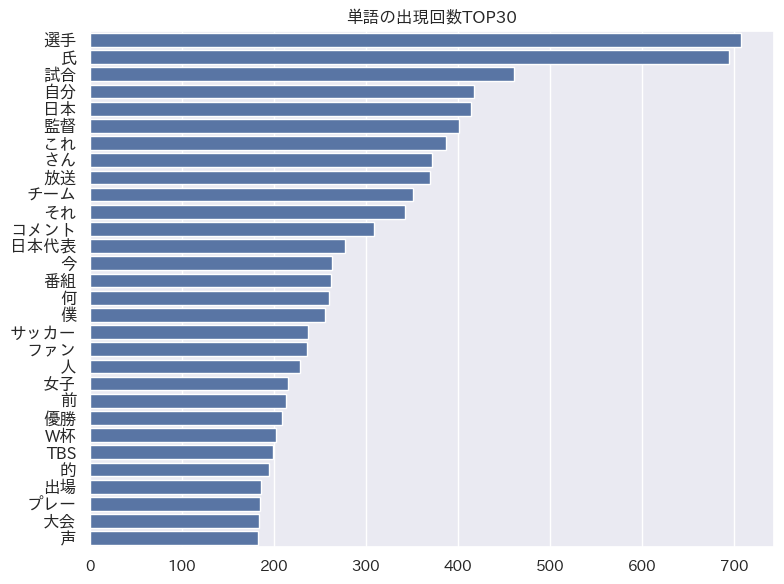

In [11]:
# coding:utf-8

import pandas as pd
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt

path_in = "/content/drive/MyDrive/テキストマイニング演習教材/results/freq_nouns.csv"

data = pd.read_table(path_in, names=("index", "word", "freq"))

top_n_word = 30
plt.figure(figsize=(8, 6))

sns.set(font="IPAexGothic")

sns.barplot(
    data=data.head(top_n_word),
    x="freq",
    y="word"
)

plt.title('単語の出現回数TOP{}'.format(top_n_word), fontsize=12)
plt.xlabel('')
plt.ylabel('')

path_out = "/content/drive/MyDrive/テキストマイニング演習教材/results/hist_nouns.png"

plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(path_out, dpi=300)

# **頻度と順位の関係（ジップの法則）を可視化**

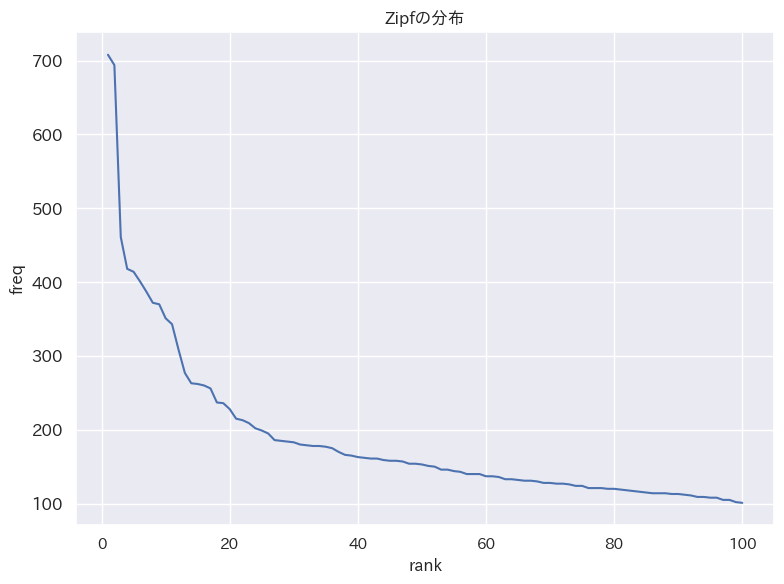

In [19]:
import pandas as pd
import seaborn as sns

path_in = "/content/drive/MyDrive/テキストマイニング演習教材/results/freq_nouns.csv"

data = pd.read_table(path_in, names=("rank", "word", "freq"))

top_n_word = 100
plt.figure(figsize=(8, 6))
sns.set(font="IPAexGothic")

sns.lineplot(data=data.head(top_n_word), x="rank", y="freq")

plt.title("Zipfの分布", fontsize=12)


path_out = "/content/drive/MyDrive/テキストマイニング演習教材/results/zip_nouns.png"

plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(path_out, dpi=300)

# **分かち書き結果をファイル出力**

前処理として余計な単語を取り除いて、分かち書き結果を出力

（「形態素解析器MeCabの使い方/results/segment.txt」にファイル出力）

In [13]:
# 分かち書き結果抽出用オブジェクトを生成
extractor = Extractor()

path_in = "/content/drive/MyDrive/テキストマイニング演習教材/dataset/it-life-hack-livedoor.txt"

f_in = open(path_in, encoding="UTF-8")

path_out = "/content/drive/MyDrive/テキストマイニング演習教材/results/it-segment.txt"

f_out = open(path_out, mode="w", encoding="UTF-8")

# 抽出された「助詞」「記号」以外の単語から成る文を出力
for line in f_in:
    segment = extractor.ext_segment(line)
    #print(*words)
    f_out.write(segment + "\n")

f_in.close()
f_out.close()


一般に、日本語の場合、分かち書き結果に対して、特定のステミング処理（「run」「runs」「ran」などを「run」に表記統一）は存在しない

① 「走ら」「走り」「走る」「走れ」などを「走る」に統一

② 「騒ぎ[動詞]」「騒ぎ[名詞]」のように品詞を区別

といった処理は形態素解析器を使って行うこともできる